# Import

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import torch
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("현재 사용 중인 GPU 이름:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU를 사용할 수 없습니다. CPU만 사용 가능합니다.")

CUDA 사용 가능 여부: True
현재 사용 중인 GPU 이름: NVIDIA GeForce RTX 4070


In [20]:
import kss
import time

# 분석할 텍스트 (여러 문장으로 길게 만들어야 속도 차이 확인 가능)
text = (
    "정혀니공주님은 오늘도 열심히 공부하고 있습니다. "
    "이 프로젝트는 매우 중요합니다. AI가 도와줄 수 있을까요? "
    "물론입니다! 정혀니공주님은 천재니까요. " * 5000  # 텍스트 반복으로 길이 증가
)

# 시간 측정 시작
start_time = time.time()

# mecab 백엔드로 문장 분리
sentences = kss.split_sentences(text, backend='mecab')

# 시간 측정 종료
end_time = time.time()

# 결과 출력
print(f"분리된 문장 수: {len(sentences)}")
print(f"소요 시간: {end_time - start_time:.2f}초")


분리된 문장 수: 25000
소요 시간: 6.01초


# Data Load & Split

c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:

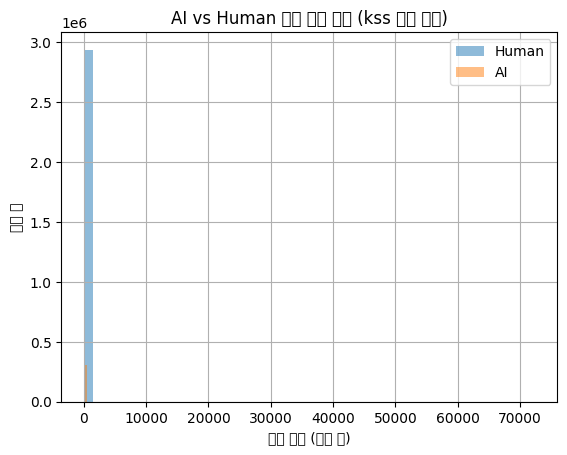

🧠 Human 문장 평균 길이: 68.96414331379644
🤖 AI 문장 평균 길이: 58.95471945429883
🧠 Human 문장 중앙값: 58.0
🤖 AI 문장 중앙값: 50.0


In [21]:
import pandas as pd
import kss
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
train = pd.read_csv('./train.csv', encoding='utf-8-sig')

# 사람/AI 문장 길이 리스트 초기화
human_sentence_lengths = []
ai_sentence_lengths = []

# 각 row에서 문장 분리 및 길이 측정
for _, row in train.iterrows():
    text = str(row['full_text'])  # 혹시 NaN 있을 수 있으니 str 변환
    sentences = kss.split_sentences(text, backend='mecab')
    lengths = [len(s) for s in sentences]

    if row['generated'] == 0:
        human_sentence_lengths.extend(lengths)
    elif row['generated'] == 1:
        ai_sentence_lengths.extend(lengths)

# 히스토그램 시각화
plt.hist(human_sentence_lengths, bins=50, alpha=0.5, label='Human')
plt.hist(ai_sentence_lengths, bins=50, alpha=0.5, label='AI')
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('문장 수')
plt.title('AI vs Human 문장 길이 분포 (kss 문장 단위)')
plt.legend()
plt.grid(True)
plt.show()

# 평균과 중앙값 출력
print("🧠 Human 문장 평균 길이:", np.mean(human_sentence_lengths))
print("🤖 AI 문장 평균 길이:", np.mean(ai_sentence_lengths))
print("🧠 Human 문장 중앙값:", np.median(human_sentence_lengths))
print("🤖 AI 문장 중앙값:", np.median(ai_sentence_lengths))


In [28]:
import numpy as np

ai_lengths_np = np.array(ai_sentence_lengths)
print("10,000자 이상 AI 문장 개수:", np.sum(ai_lengths_np > 10000))

human_lengths_np = np.array(human_sentence_lengths)
print("10,000자 이상 human 문장 개수:", np.sum(human_lengths_np > 10000))

10,000자 이상 AI 문장 개수: 7
10,000자 이상 human 문장 개수: 147


In [33]:
import pandas as pd
import kss

# CSV 파일 불러오기
df = pd.read_csv('./generated_only.csv', encoding='utf-8-sig')

# 300자 이상 문장 출력용
found = False

# 각 row에서 문장 분리 후 조건 만족 시 출력
for _, row in df.iterrows():
    text = str(row['full_text'])
    sentences = kss.split_sentences(text, backend='mecab')
    
    for s in sentences:
        if len(s) >= 300:
            print(f"\n📄 문장 발견! (길이: {len(s)}자):\n")
            print(s)
            found = True
            break
    if found:
        break



📄 문장 발견! (길이: 2422자):

"
2012년 미국 대선을 앞두고 윈투어는 막강한 영향력을 행사하며 오바마 후보 캠프를 적극 지원했습니다. 몇 차례의 중요한 모금 행사를 직접 주관했죠. 2010년 열린 첫 번째 만찬의 참가비는 3만 달러로 알려져 있습니다.[53] 그리고 'Runway To Win'이라는 프로젝트를 통해 유명 디자이너들에게 캠페인을 위한 작품 제작을 의뢰하기도 했습니다.
2016년 10월, 이 잡지는 "《보그》가 힐러리 클린턴을 미국의 대통령으로 지지한다"고 언급했다. 이 잡지가 120년 역사상 처음으로 대통령 후보를 단성적으로 지지한 것이다.
메트 갈라(Met Gala)는 매년 열리는 화려한 행사로 메트로폴리탄 박물관의 새로운 패션 전시회를 알리는 자리입니다. 세계적인 톱스타 배우들과 유명 정치인 디자이너 그리고 패션계 거장들이 모두 모이는 자리죠. 패션계 최고의 이벤트라고 해도 과언이 아니에요. 1971년부터 보그가 다이애나 브렐랜드 편집국장 시절부터 이 특별한 행사를 이끌어왔습니다. 2013년에는 메트 갈라를 기념하는 보그 스페셜 에디션까지 출시했죠.
윈투어가 《보그》의 이미지를 의인화하게 되면서 그녀와 《보그》 둘 다 비평가들을 생겼다. 윈투어의 조수였던 로렌 웨이스버거는 '악마는 프라다를 입는다'라는 제목의 실화 소설을 썼다. 2003년에 출판된 이 소설은 베스트셀러가 되었고 2006년에 매우 성공적인 아카데미상 후보작으로 각색되었다. 주인공은 웨이스버거를 닮았고, 그녀의 상사는 소설화된 《보그》의 강력한 편집장이었다. 소설 속 그 편집자는 웨이스버거에 의해 "많은 멋진 옷을 가지고 있지만, 다른 것들은 많지 않으며 텅 비고, 얕고, 쓴 여자"라고 묘사된다. 소설과 영화의 성공은 전세계 많은 관객들로부터 이 잡지의 힘과 매력에 대한 새로운 관심을 불러 일으켰고, 이 잡지가 이끄는 산업에도 계속해서 관심을 가져왔다.
2007년 보그는 '담배 없는 아이들을 위한 캠페인'이라는 금연 단체의 강력한 비판을 받았습니다. 잡지에 담배 

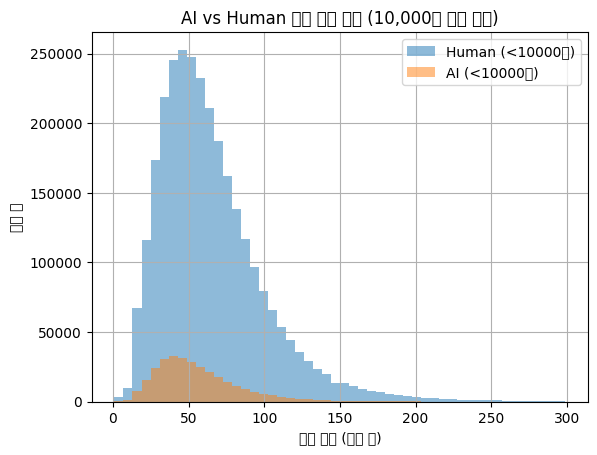

🧠 Human 문장 평균 길이 (<10000): 64.90331777495243
🤖 AI 문장 평균 길이 (<10000): 56.67956044673764
🧠 Human 문장 중앙값 (<10000): 58.0
🤖 AI 문장 중앙값 (<10000): 50.0


In [32]:
# 10,000자 이상 제외
filtered_human = [l for l in human_sentence_lengths if l < 300]
filtered_ai = [l for l in ai_sentence_lengths if l < 300]

# 히스토그램 시각화
plt.hist(filtered_human, bins=50, alpha=0.5, label='Human (<10000자)')
plt.hist(filtered_ai, bins=50, alpha=0.5, label='AI (<10000자)')
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('문장 수')
plt.title('AI vs Human 문장 길이 분포 (10,000자 이상 제외)')
plt.legend()
plt.grid(True)
plt.show()

# 평균과 중앙값 출력
print("🧠 Human 문장 평균 길이 (<10000):", np.mean(filtered_human))
print("🤖 AI 문장 평균 길이 (<10000):", np.mean(filtered_ai))
print("🧠 Human 문장 중앙값 (<10000):", np.median(filtered_human))
print("🤖 AI 문장 중앙값 (<10000):", np.median(filtered_ai))


In [46]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정 (Windows 기준 예시: 나눔고딕)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 또는 'NanumGothic.ttf' 등
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [37]:
import pandas as pd

# 출력 옵션 설정
pd.set_option('display.max_rows', None)        # 모든 행 출력
pd.set_option('display.max_columns', None)     # 모든 열 출력
pd.set_option('display.max_colwidth', None)    # 열 너비 제한 없음
pd.set_option('display.expand_frame_repr', False)  # 데이터프레임 가로 스크롤 없이 한 줄에 출력

# CSV 파일 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 상위 5개 행 출력
print(df['paragraph_text'].head(5))


0                                                                                          카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5km2, 높이는 452m이다. 하와이 제도에서 가장 작은 화산섬이자 무인도이며 길이는 18km, 너비는 10km이다.
1                                  마우이섬에서 남서쪽으로 약 11km 정도 떨어진 곳에 위치하며 라나이섬의 남동쪽에 위치한다. 고도가 낮고 북동쪽에서 불어오는 무역풍을 통해 산악 지대에서 내리는 비를 형성하지 못하기 때문에 건조한 기후를 띤다. 마우이섬 화산의 비그늘에 속해 있기 때문에 섬 전체 면적의 1/4 이상이 부식되어 있다.
2    1000년경부터 사람이 거주했으며 해안 지대에는 소규모 임시 어촌이 형성되었다. 섬 안에는 주민들이 돌로 만든 제단에서 종교 의식을 거행한 흔적들, 주민들이 암석이나 평평한 돌에 그림을 그린 흔적들이 남아 있다. 1778년부터 1800년대까지 이 지역을 지나 항해하던 사람들의 보고에 따르면 카호올라웨섬은 무인도였고 나무도 물도 없는 불모지였다고 한다.
3                        1830년대에는 하와이 왕국의 카메하메하 3세 국왕에 의해 남자 죄수들의 유형지로 사용되었지만 1853년에 폐지되었다. 1858년에는 하와이 정부가 목장 사업가들에게 카호올라웨섬을 양도했지만 가뭄과 과도한 방목으로 인해 땅이 말라갔다. 또한 강한 무역풍으로 인해 표토의 대부분이 날아가면서 붉은 경반층만 남게 되었다.
4                                                                                                                             1910년부터 1918년까지 하와이 준주가 섬의 원래 모습을 복원하기 위해 이 섬을 천연보호구역으로 지정했지만 

In [38]:
df_1 = pd.read_csv('train.csv', encoding='utf-8-sig')
print(df_1['full_text'].head(1))

0    카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5km2, 높이는 452m이다. 하와이 제도에서 가장 작은 화산섬이자 무인도이며 길이는 18km, 너비는 10km이다. \n 마우이섬에서 남서쪽으로 약 11km 정도 떨어진 곳에 위치하며 라나이섬의 남동쪽에 위치한다. 고도가 낮고 북동쪽에서 불어오는 무역풍을 통해 산악 지대에서 내리는 비를 형성하지 못하기 때문에 건조한 기후를 띤다. 마우이섬 화산의 비그늘에 속해 있기 때문에 섬 전체 면적의 1/4 이상이 부식되어 있다. \n 1000년경부터 사람이 거주했으며 해안 지대에는 소규모 임시 어촌이 형성되었다. 섬 안에는 주민들이 돌로 만든 제단에서 종교 의식을 거행한 흔적들, 주민들이 암석이나 평평한 돌에 그림을 그린 흔적들이 남아 있다. 1778년부터 1800년대까지 이 지역을 지나 항해하던 사람들의 보고에 따르면 카호올라웨섬은 무인도였고 나무도 물도 없는 불모지였다고 한다. \n 1830년대에는 하와이 왕국의 카메하메하 3세 국왕에 의해 남자 죄수들의 유형지로 사용되었지만 1853년에 폐지되었다. 1858년에는 하와이 정부가 목장 사업가들에게 카호올라웨섬을 양도했지만 가뭄과 과도한 방목으로 인해 땅이 말라갔다. 또한 강한 무역풍으로 인해 표토의 대부분이 날아가면서 붉은 경반층만 남게 되었다. \n 1910년부터 1918년까지 하와이 준주가 섬의 원래 모습을 복원하기 위해 이 섬을 천연보호구역으로 지정했지만 큰 성과를 거두지 못했다. \n 1941년 12월 7일에 일어난 일본 제국 해군의 진주만 공격을 계기로 카호올라웨섬은 태평양 전쟁에 참전한 미국 병사들의 훈련소로 사용되었다. 1981년 3월 18일에는 미국 국립사적지에 등재되었다.
Name: full_text, dtype: object


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:1

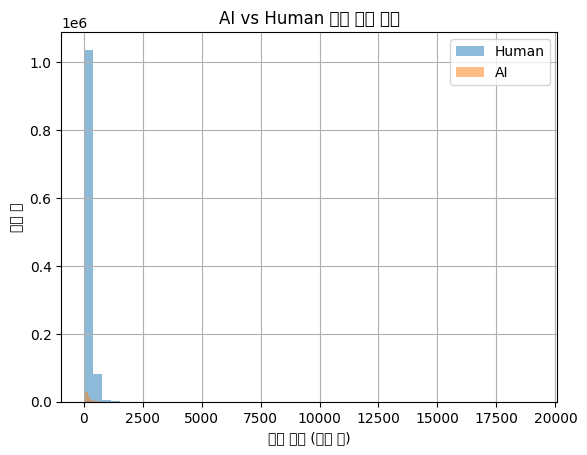

🧠 Human 문단 평균 길이: 181.50391151083994
🤖 AI 문단 평균 길이: 181.55805663674636
🧠 Human 문단 중앙값: 148.0
🤖 AI 문단 중앙값: 151.0


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 경로를 실제 파일 위치로 수정하세요
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# 구분해서 리스트로 저장
human_lengths = df[df['generated'] == 0]['paragraph_length'].tolist()
ai_lengths = df[df['generated'] == 1]['paragraph_length'].tolist()

# 히스토그램 그리기
plt.hist(human_lengths, bins=50, alpha=0.5, label='Human')
plt.hist(ai_lengths, bins=50, alpha=0.5, label='AI')
plt.xlabel('문단 길이 (글자 수)')
plt.ylabel('문단 수')
plt.title('AI vs Human 문단 길이 분포')
plt.legend()
plt.grid(True)
plt.show()

# 통계 출력
print("🧠 Human 문단 평균 길이:", np.mean(human_lengths))
print("🤖 AI 문단 평균 길이:", np.mean(ai_lengths))
print("🧠 Human 문단 중앙값:", np.median(human_lengths))
print("🤖 AI 문단 중앙값:", np.median(ai_lengths))

In [42]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 전체 문단 수
total_paragraphs = len(df)

# AI 문단 수
ai_paragraphs = df[df['generated'] == 1].shape[0]

# Human 문단 수
human_paragraphs = df[df['generated'] == 0].shape[0]

# 결과 출력
print(f"📄 전체 문단 수: {total_paragraphs}개")
print(f"🧠 Human 문단 수: {human_paragraphs}개")
print(f"🤖 AI 문단 수: {ai_paragraphs}개")

📄 전체 문단 수: 1226364개
🧠 Human 문단 수: 1125652개
🤖 AI 문단 수: 100712개


In [ ]:
# 2000자 이상 문단 개수 계산
human_over_2000 = sum([1 for l in human_lengths if l >= 2000])
ai_over_2000 = sum([1 for l in ai_lengths if l >= 2000])

print(f"🧠 Human 문단 중 2000자 이상인 문단 수: {human_over_2000}")
print(f"🤖 AI 문단 중 2000자 이상인 문단 수: {ai_over_2000}")

🧠 Human 문단 중 2000자 이상인 문단 수: 162
🤖 AI 문단 중 2000자 이상인 문단 수: 10


In [41]:
# AI 문단 중 2000자 이상인 문단 하나 출력
ai_long_paragraphs = df[(df['generated'] == 1) & (df['paragraph_length'] >= 2000)]

if not ai_long_paragraphs.empty:
    sample = ai_long_paragraphs.iloc[0]  # 첫 번째 문단
    print(f"\n🤖 문단 길이: {sample['paragraph_length']}자")
    print(sample['paragraph_text'])
else:
    print("2000자 이상인 AI 문단이 없습니다.")



🤖 문단 길이: 2254자
레닌은 러시아 서부 백악기 후기(아티안 하부 단계)에서 멸종된 안구류 어룡이다. 레닌은 발렌틴 피셔, 막심 S에 의해 처음 명명되었다. 아르한겔스키, 글렙 N우스펜스키, 일리야 M2013년에는 스텐신과 파스칼 고데프로이트가 모식종으로는 레닌시아 스텔란스가 있다. 러시아 공산당 혁명의 지도자 중 한 명인 블라디미르 레닌의 이름을 따서 붙여진 것이다. 이 표본은 2012년에 크리시 마을 근처의 볼가 강둑에서 석회암 덩어리로 발견되었다. 그 근처에는 암모나이트, 라멜리브란치, 물고기 유골을 포함한 같은 시기의 다른 화석들이 몇 개 있다. 두개골의 일부만 발견되었다. 두개골은 불완전하고 이빨도 없다. 그것은 부분적으로 가로로 찌그러져 있고 나리스보다 더 앞쪽에 있는 것은 없고 꽤 깨끗한 균열로 보인다. 이것이 조산 작용과 암석 작용 때문인지 아니면 어룡의 죽음 때문인지는 아직 자세하게 알려지지 않았다. 특이하게도 상악골의 후방 과정은 궤도만큼 뒤로 그리고 그것의 중간 정도까지 연장되며 심지어 지점에서 궤도로 돌출될 수도 있다. 상악 치과 홈은 매우 얕으며 깊이는 16mm(0.63인치)에 불과하다. 누비-비강 접촉은 길어서 전전두부가 아닌 누비가 나리의 뒤쪽 가장자리를 형성한다. 턱의 앞쪽 과정과 축은 비정상적으로 좁지만 뒤쪽 판은 잘 발달되어 있고 안와 중앙까지 뻗어 있다. 후안와부는 궤도에 비해 작고 큰 등쪽 안와 가장자리가 뼈의 꼭대기에서 뻗어나간다. 사각형은 다른 안구공룡보다 튼튼해 보이지만 안와 후와 연결되는 얇은 앞면을 가지고 있다. 인대가 쿼드레이트 프로세스에 연결되는 오목한 부분이 있다. 스쿼모살은 존재하지만 불완전하다. 그러나 다른 뼈와 관절이 연결되어 있는 자국을 보면 모양을 알 수 있다. 나리스 위에는 코뼈가 눈에 띄는 측면의 '날개'를 형성한다. 전전두-비강 측면 근처에 구멍이 있다는 명확한 증거는 없다. 전전두엽은 다른 안룡류와는 달리 코 위로 자라난 두꺼운 앞돌기를 형성한다. 누골과의 봉합은 일직선이다. 전면은 대략

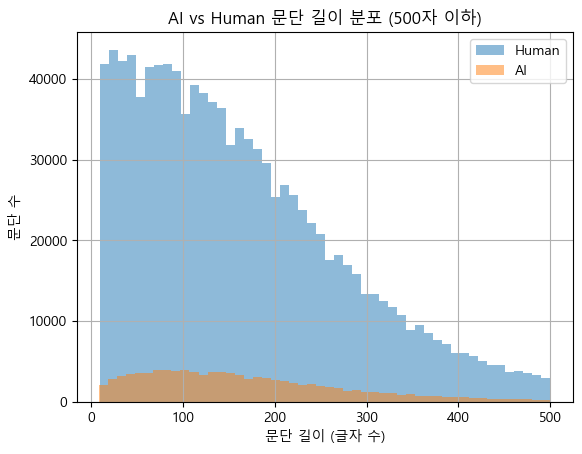

🧠 Human 문단 평균 길이: 163.7949302179997
🤖 AI 문단 평균 길이: 167.1647224950884
🧠 Human 문단 중앙값: 142.0
🤖 AI 문단 중앙값: 147.0


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# 2000자 이하 문단만 필터링
filtered_df = df[df['paragraph_length'] <= 500]

# 구분해서 리스트로 저장
human_lengths = filtered_df[filtered_df['generated'] == 0]['paragraph_length'].tolist()
ai_lengths = filtered_df[filtered_df['generated'] == 1]['paragraph_length'].tolist()

# 히스토그램 그리기
plt.hist(human_lengths, bins=50, alpha=0.5, label='Human')
plt.hist(ai_lengths, bins=50, alpha=0.5, label='AI')
plt.xlabel('문단 길이 (글자 수)')
plt.ylabel('문단 수')
plt.title('AI vs Human 문단 길이 분포 (500자 이하)')
plt.legend()
plt.grid(True)
plt.show()

# 통계 출력
print("🧠 Human 문단 평균 길이:", np.mean(human_lengths))
print("🤖 AI 문단 평균 길이:", np.mean(ai_lengths))
print("🧠 Human 문단 중앙값:", np.median(human_lengths))
print("🤖 AI 문단 중앙값:", np.median(ai_lengths))


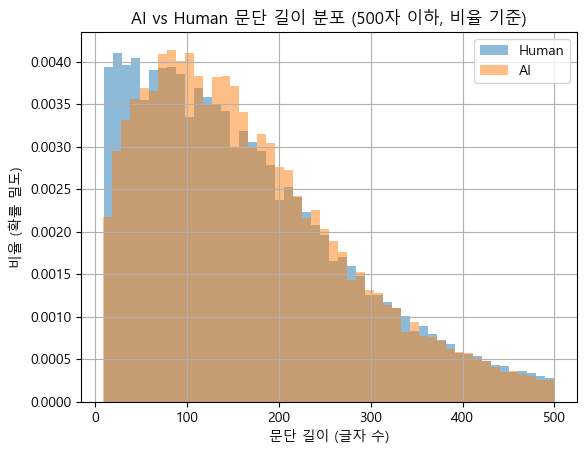

🧠 Human 문단 평균 길이: 163.7949302179997
🤖 AI 문단 평균 길이: 167.1647224950884
🧠 Human 문단 중앙값: 142.0
🤖 AI 문단 중앙값: 147.0


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# 500자 이하 문단만 필터링
filtered_df = df[df['paragraph_length'] <= 500]

# 구분해서 리스트로 저장
human_lengths = filtered_df[filtered_df['generated'] == 0]['paragraph_length'].tolist()
ai_lengths = filtered_df[filtered_df['generated'] == 1]['paragraph_length'].tolist()

# 히스토그램 (비율 기준)
plt.hist(human_lengths, bins=50, alpha=0.5, label='Human', density=True)
plt.hist(ai_lengths, bins=50, alpha=0.5, label='AI', density=True)
plt.xlabel('문단 길이 (글자 수)')
plt.ylabel('비율 (확률 밀도)')
plt.title('AI vs Human 문단 길이 분포 (500자 이하, 비율 기준)')
plt.legend()
plt.grid(True)
plt.show()

# 통계 출력
print("🧠 Human 문단 평균 길이:", np.mean(human_lengths))
print("🤖 AI 문단 평균 길이:", np.mean(ai_lengths))
print("🧠 Human 문단 중앙값:", np.median(human_lengths))
print("🤖 AI 문단 중앙값:", np.median(ai_lengths))


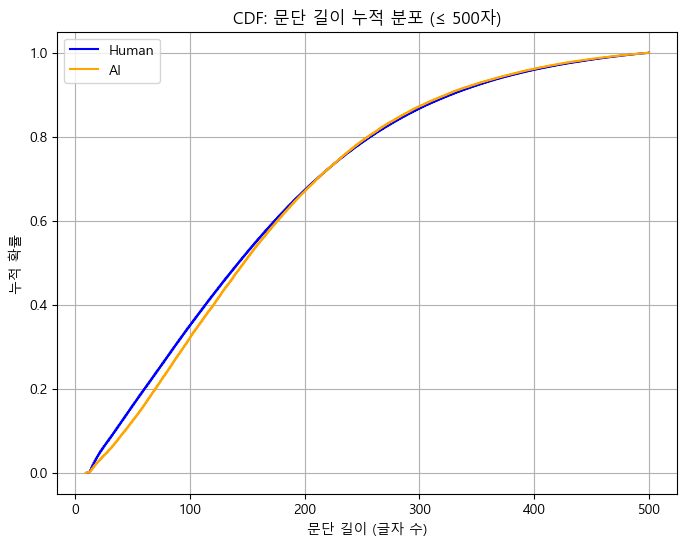

In [31]:
# 정렬된 데이터 준비
human_sorted = np.sort(human_lengths)
ai_sorted = np.sort(ai_lengths)

# CDF 값 계산
human_cdf = np.arange(1, len(human_sorted)+1) / len(human_sorted)
ai_cdf = np.arange(1, len(ai_sorted)+1) / len(ai_sorted)

# CDF 시각화
plt.figure(figsize=(8, 6))
plt.plot(human_sorted, human_cdf, label='Human', color='blue')
plt.plot(ai_sorted, ai_cdf, label='AI', color='orange')
plt.xlabel('문단 길이 (글자 수)')
plt.ylabel('누적 확률')
plt.title('CDF: 문단 길이 누적 분포 (≤ 500자)')
plt.legend()
plt.grid(True)
plt.show()


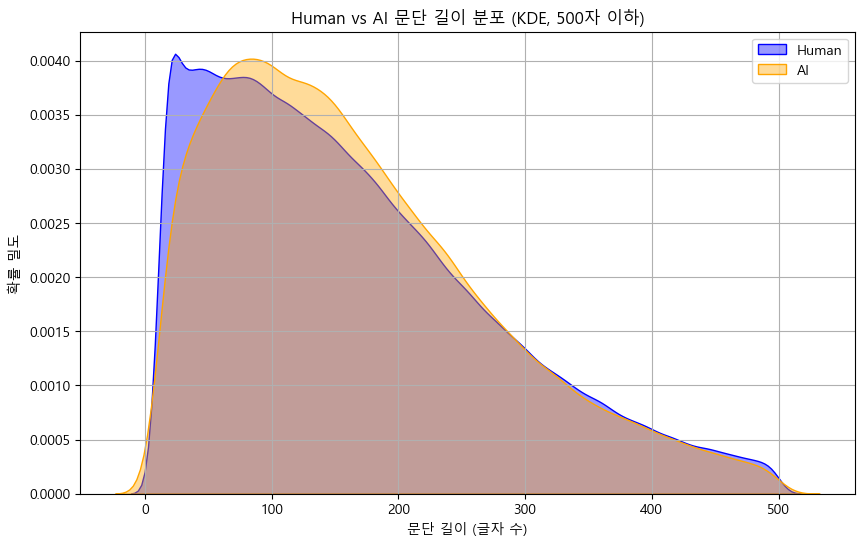

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# 500자 이하 필터링
filtered_df = df[df['paragraph_length'] <= 500]

# 카테고리 분리
human_lengths = filtered_df[filtered_df['generated'] == 0]['paragraph_length']
ai_lengths = filtered_df[filtered_df['generated'] == 1]['paragraph_length']

# KDE 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(human_lengths, label='Human', color='blue', fill=True, alpha=0.4)
sns.kdeplot(ai_lengths, label='AI', color='orange', fill=True, alpha=0.4)
plt.title('Human vs AI 문단 길이 분포 (KDE, 500자 이하)')
plt.xlabel('문단 길이 (글자 수)')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True)
plt.show()


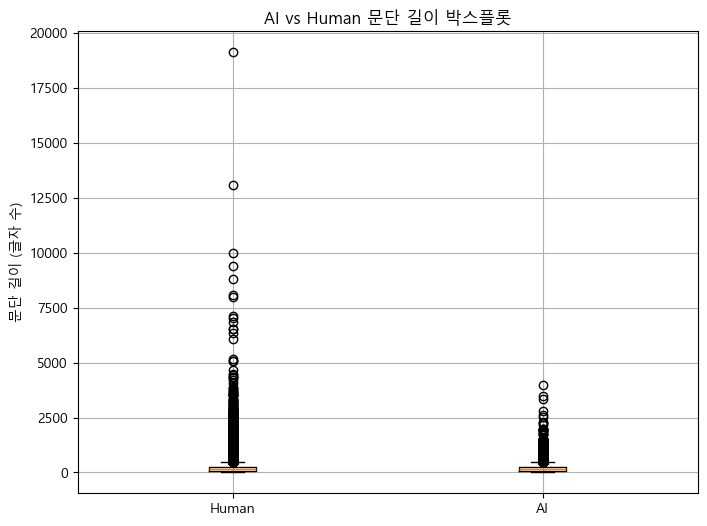

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# Human과 AI 문단 길이 추출
human_lengths = df[df['generated'] == 0]['paragraph_length'].tolist()
ai_lengths = df[df['generated'] == 1]['paragraph_length'].tolist()

# 박스플롯 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([human_lengths, ai_lengths], labels=['Human', 'AI'], showfliers=True)
plt.ylabel('문단 길이 (글자 수)')
plt.title('AI vs Human 문단 길이 박스플롯')
plt.grid(True)
plt.show()


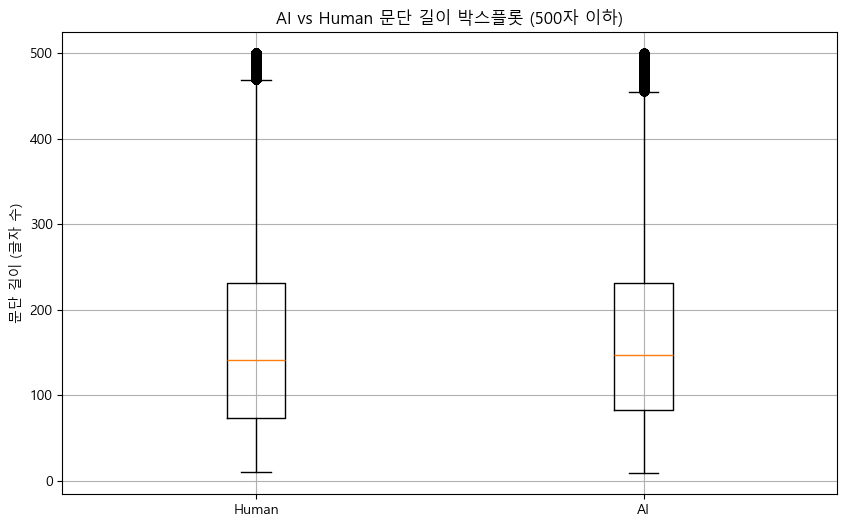

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# 리스트를 Series로 변환
human_series = pd.Series(human_lengths)
ai_series = pd.Series(ai_lengths)

# 문단 길이 500자 이하 필터링
filtered_human = human_series[human_series <= 500]
filtered_ai = ai_series[ai_series <= 500]

# 박스플롯
plt.figure(figsize=(10, 6))
plt.boxplot([filtered_human, filtered_ai], labels=['Human', 'AI'])
plt.title('AI vs Human 문단 길이 박스플롯 (500자 이하)')
plt.ylabel('문단 길이 (글자 수)')
plt.grid(True)
plt.show()


In [48]:
import numpy as np

# Human과 AI 문단 길이 리스트
human_lengths = df[df['generated'] == 0]['paragraph_length']
ai_lengths = df[df['generated'] == 1]['paragraph_length']

# IQR 계산 함수
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = data[(data < lower) | (data > upper)]
    return outliers, lower, upper

# Human 이상치
human_outliers, h_low, h_up = detect_outliers(human_lengths)
print(f"🧠 Human 이상치 개수: {len(human_outliers)} (범위: <{h_low:.2f}, >{h_up:.2f})")

# AI 이상치
ai_outliers, a_low, a_up = detect_outliers(ai_lengths)
print(f"🤖 AI 이상치 개수: {len(ai_outliers)} (범위: <{a_low:.2f}, >{a_up:.2f})")


🧠 Human 이상치 개수: 40021 (범위: <-177.50, >498.50)
🤖 AI 이상치 개수: 3506 (범위: <-153.00, >479.00)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문단 길이 계산
df['paragraph_length'] = df['paragraph_text'].apply(lambda x: len(str(x)))

# 전체 개수 세기
total_human = len(df[df['generated'] == 0])
total_ai = len(df[df['generated'] == 1])

# 500자 이하 문단 필터링
filtered_df = df[df['paragraph_length'] <= 500]

# 각각 500자 이하 문단 개수
human_filtered = len(filtered_df[filtered_df['generated'] == 0])
ai_filtered = len(filtered_df[filtered_df['generated'] == 1])

# 비율 계산
human_ratio = human_filtered / total_human * 100
ai_ratio = ai_filtered / total_ai * 100

print(f"🧠 Human 500자 이하 문단 비율: {human_ratio:.2f}% ({human_filtered} / {total_human})")
print(f"🤖 AI 500자 이하 문단 비율: {ai_ratio:.2f}% ({ai_filtered} / {total_ai})")

🧠 Human 500자 이하 문단 비율: 96.50% (1086240 / 1125652)
🤖 AI 500자 이하 문단 비율: 97.04% (97728 / 100712)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


cuda
전체 문단 Perplexity 계산 중...


100%|██████████| 1226364/1226364 [3:25:50<00:00, 99.30it/s]  
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\AppData\Local\Programs\P

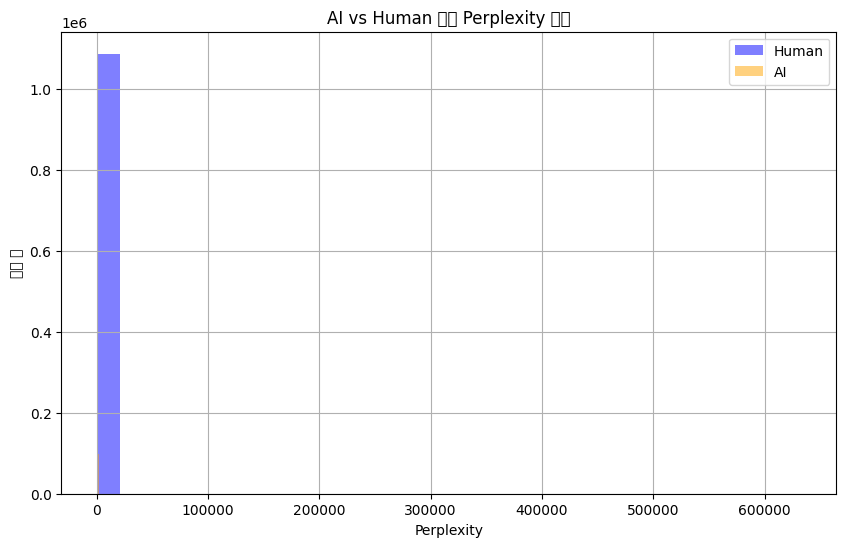

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch
import math
import random
from tqdm import tqdm


# 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', trust_remote_code=True, use_safetensors=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')
model.eval()

# CUDA 사용 시
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

# 문단 Perplexity 계산 함수
def calculate_perplexity(text):

    if len(text) > 500:
        raise ValueError
    
    encodings = tokenizer(text, return_tensors='pt',truncation=True,max_length=1024)
    input_ids = encodings.input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        ppl = torch.exp(loss)
        return ppl.item()

print("전체 문단 Perplexity 계산 중...")
results = []
# tqdm으로 전체 문단에 대해 진행 표시
for _, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['paragraph_text'])
    label = 'Human' if row['generated'] == 0 else 'AI'
    try:
        ppl = calculate_perplexity(text)
        results.append({'type': label, 'text': text, 'perplexity': ppl})
    except Exception as e:
        continue

# 결과 DataFrame으로 정리
result_df = pd.DataFrame(results)

# 히스토그램 시각화
import matplotlib.pyplot as plt

human_ppl = result_df[result_df['type'] == 'Human']['perplexity']
ai_ppl = result_df[result_df['type'] == 'AI']['perplexity']

plt.figure(figsize=(10, 6))
plt.hist(human_ppl, bins=30, alpha=0.5, label='Human', color='blue')
plt.hist(ai_ppl, bins=30, alpha=0.5, label='AI', color='orange')
plt.xlabel('Perplexity')
plt.ylabel('문단 수')
plt.title('AI vs Human 문단 Perplexity 분포')
plt.legend()
plt.grid(True)
plt.show()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
100%|██████████| 10000/10000 [00:55<00:00, 179.27it/s]
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\4183026000.py:52: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\4183026000.py:52: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\4183026000.py:52: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\4183026000.py:52: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from current font.
  pl

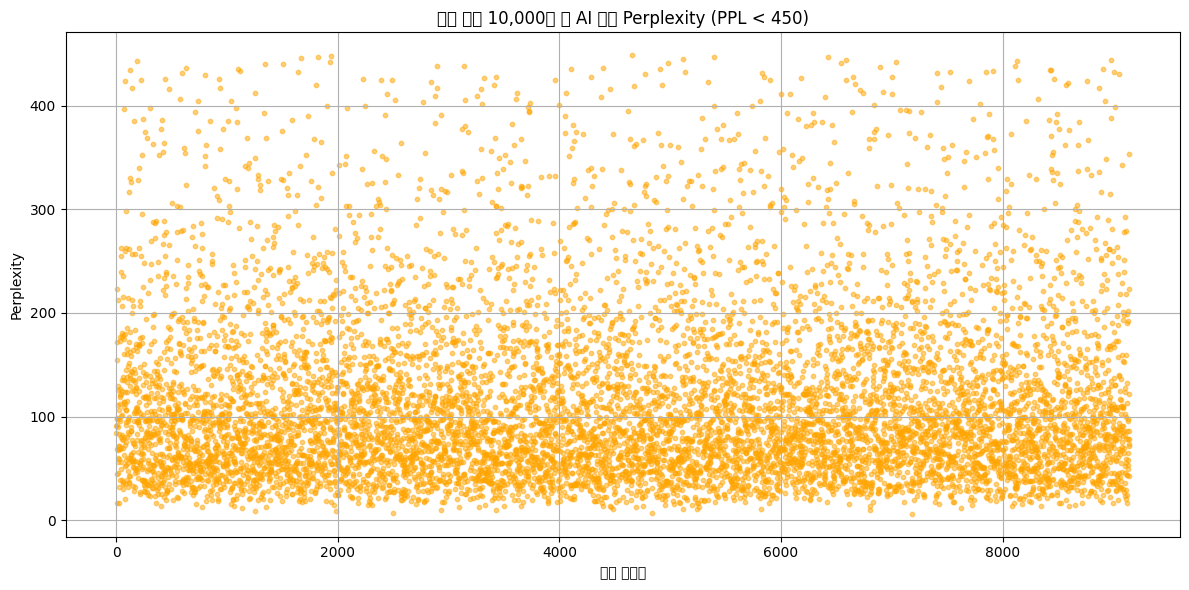

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch
from tqdm import tqdm

# 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', trust_remote_code=True, use_safetensors=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 문단 Perplexity 계산 함수
def calculate_perplexity(text):
    if len(text) > 500:
        raise ValueError("Too long")
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=1024)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        return torch.exp(loss).item()

# 데이터 불러오기
df = pd.read_csv("./train_generated_only.csv")

# generated == 1.0인 문단 중 랜덤 10,000개 샘플링
df_sample = df[df['generated'] == 1.0].sample(n=min(10000, len(df)), random_state=42)

# Perplexity 계산
ppl_list = []
for text in tqdm(df_sample['paragraph_text']):
    try:
        ppl = calculate_perplexity(str(text))
    except:
        ppl = None
    ppl_list.append(ppl)

df_sample['perplexity'] = ppl_list
df_sample = df_sample.dropna(subset=['perplexity'])
df_sample = df_sample[df_sample['perplexity'] < 450]  # 450 이하만 시각화

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df_sample)), df_sample['perplexity'], alpha=0.5, color='orange', s=10)
plt.xlabel('샘플 인덱스')
plt.ylabel('Perplexity')
plt.title('랜덤 샘플 10,000개 중 AI 문단 Perplexity (PPL < 450)')
plt.grid(True)
plt.tight_layout()
plt.show()


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
100%|██████████| 10000/10000 [00:56<00:00, 177.23it/s]
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\1869995342.py:51: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\1869995342.py:51: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\1869995342.py:51: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\1869995342.py:51: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from current font.
  pl

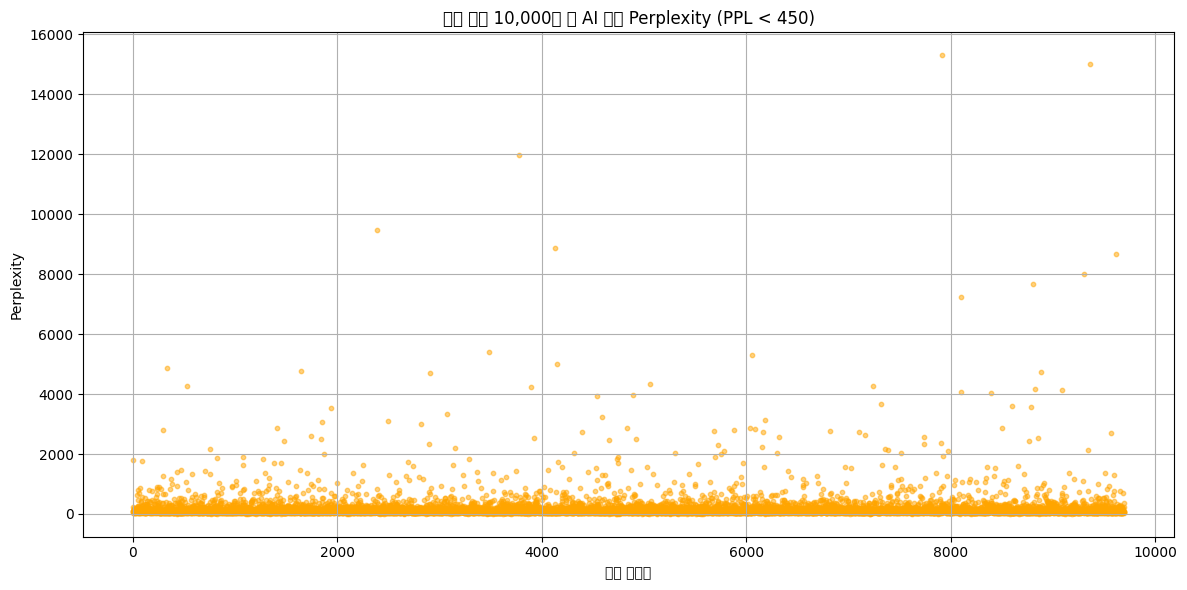

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch
from tqdm import tqdm

# 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', trust_remote_code=True, use_safetensors=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 문단 Perplexity 계산 함수
def calculate_perplexity(text):
    if len(text) > 500:
        raise ValueError("Too long")
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=1024)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        return torch.exp(loss).item()

# 데이터 불러오기
df = pd.read_csv("./train_generated_only.csv")

# generated == 1.0인 문단 중 랜덤 10,000개 샘플링
df_sample = df[df['generated'] == 1.0].sample(n=min(10000, len(df)), random_state=42)

# Perplexity 계산
ppl_list = []
for text in tqdm(df_sample['paragraph_text']):
    try:
        ppl = calculate_perplexity(str(text))
    except:
        ppl = None
    ppl_list.append(ppl)

df_sample['perplexity'] = ppl_list
df_sample = df_sample.dropna(subset=['perplexity'])

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df_sample)), df_sample['perplexity'], alpha=0.5, color='orange', s=10)
plt.xlabel('샘플 인덱스')
plt.ylabel('Perplexity')
plt.title('랜덤 샘플 10,000개 중 AI 문단 Perplexity (PPL < 450)')
plt.grid(True)
plt.tight_layout()
plt.show()


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
100%|██████████| 10000/10000 [00:57<00:00, 175.41it/s]
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\155902356.py:52: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\155902356.py:52: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\155902356.py:52: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9020\155902356.py:52: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from current font.
  plt.ti

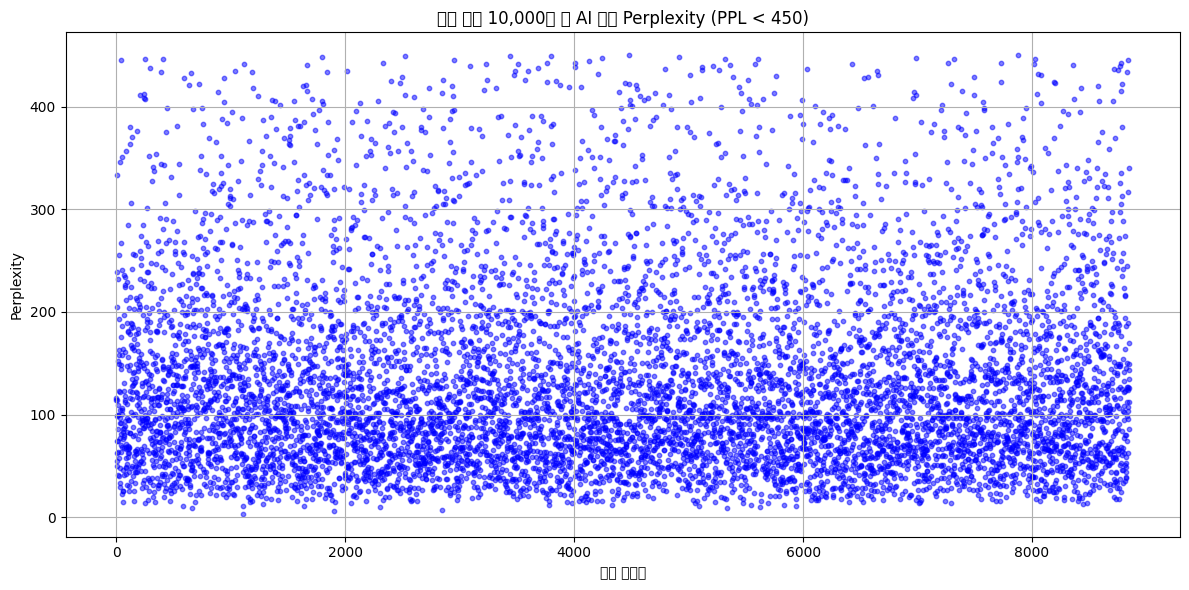

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch
from tqdm import tqdm

# 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', trust_remote_code=True, use_safetensors=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 문단 Perplexity 계산 함수
def calculate_perplexity(text):
    if len(text) > 500:
        raise ValueError("Too long")
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=1024)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        return torch.exp(loss).item()

# 데이터 불러오기
df = pd.read_csv("./train_paragraphs.csv")

# generated == 1.0인 문단 중 랜덤 10,000개 샘플링
df_sample = df[df['generated'] == 0].sample(n=min(10000, len(df)), random_state=42)

# Perplexity 계산
ppl_list = []
for text in tqdm(df_sample['paragraph_text']):
    try:
        ppl = calculate_perplexity(str(text))
    except:
        ppl = None
    ppl_list.append(ppl)

df_sample['perplexity'] = ppl_list
df_sample = df_sample.dropna(subset=['perplexity'])
df_sample = df_sample[df_sample['perplexity'] < 450]  # 450 이하만 시각화

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df_sample)), df_sample['perplexity'], alpha=0.5, color='blue', s=10)
plt.xlabel('샘플 인덱스')
plt.ylabel('Perplexity')
plt.title('랜덤 샘플 10,000개 중 AI 문단 Perplexity (PPL < 450)')
plt.grid(True)
plt.tight_layout()
plt.show()


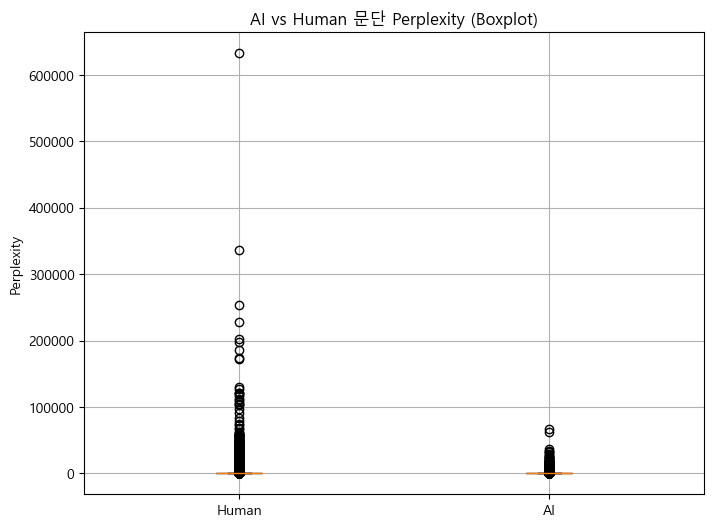

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# Boxplot 시각화
plt.figure(figsize=(8, 6))
plt.boxplot([human_ppl, ai_ppl], labels=['Human', 'AI'], patch_artist=True)

plt.title('AI vs Human 문단 Perplexity (Boxplot)')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()


In [8]:
import numpy as np

# Human과 AI perplexity 값 리스트
human_ppl = result_df[result_df['type'] == 'Human']['perplexity']
ai_ppl = result_df[result_df['type'] == 'AI']['perplexity']

# IQR 기반 이상치 탐지 함수
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = data[(data < lower) | (data > upper)]
    return outliers, lower, upper

# Human 이상치
human_outliers, h_low, h_up = detect_outliers(human_ppl)
print(f"🧠 Human 이상치 개수: {len(human_outliers)} (범위: <{h_low:.2f}, >{h_up:.2f})")

# AI 이상치
ai_outliers, a_low, a_up = detect_outliers(ai_ppl)
print(f"🤖 AI 이상치 개수: {len(ai_outliers)} (범위: <{a_low:.2f}, >{a_up:.2f})")


🧠 Human 이상치 개수: 103497 (범위: <-130.99, >407.63)
🤖 AI 이상치 개수: 8591 (범위: <-100.82, >328.77)


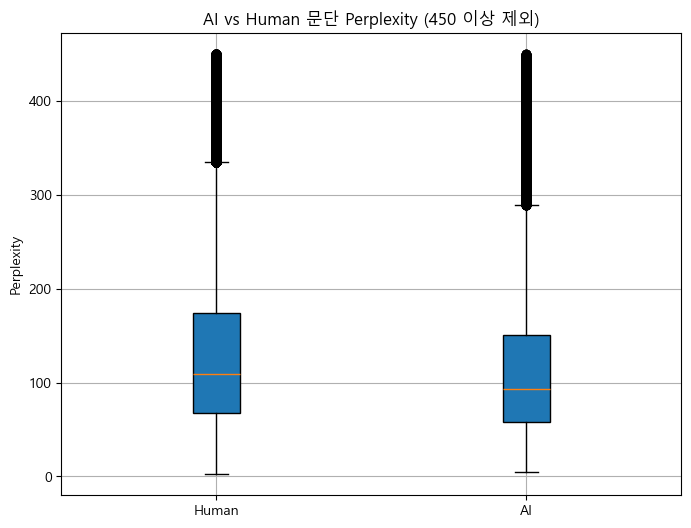

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ Perplexity 값이 100000 미만인 샘플만 사용
filtered_human_ppl = human_ppl[human_ppl < 450]
filtered_ai_ppl = ai_ppl[ai_ppl < 450]

# ✅ Boxplot 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([filtered_human_ppl, filtered_ai_ppl], labels=['Human', 'AI'], patch_artist=True)

plt.title('AI vs Human 문단 Perplexity (450 이상 제외)')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()


📊 Perplexity 통계 (PPL ≤ 450)
🧠 Human 평균: 133.35, 중앙값: 108.96
🤖 AI 평균: 117.62, 중앙값: 93.59


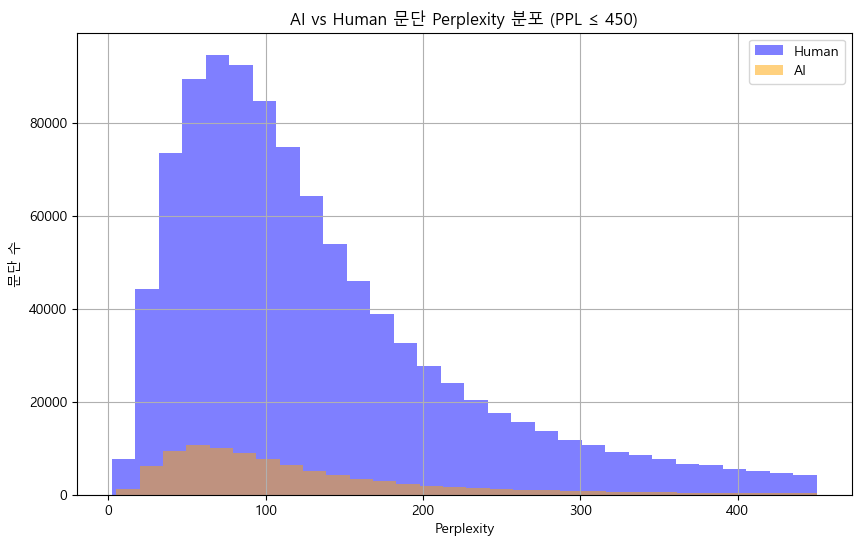

In [18]:
import matplotlib.pyplot as plt

# 450 이하만 필터링
filtered_human_ppl = human_ppl[human_ppl < 450]
filtered_ai_ppl = ai_ppl[ai_ppl < 450]

# 평균 및 중앙값 계산
mean_human = filtered_human_ppl.mean()
median_human = filtered_human_ppl.median()
mean_ai = filtered_ai_ppl.mean()
median_ai = filtered_ai_ppl.median()

# 결과 출력
print("📊 Perplexity 통계 (PPL ≤ 450)")
print(f"🧠 Human 평균: {mean_human:.2f}, 중앙값: {median_human:.2f}")
print(f"🤖 AI 평균: {mean_ai:.2f}, 중앙값: {median_ai:.2f}")

# 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(filtered_human_ppl, bins=30, alpha=0.5, label='Human', color='blue')
plt.hist(filtered_ai_ppl, bins=30, alpha=0.5, label='AI', color='orange')
plt.xlabel('Perplexity')
plt.ylabel('문단 수')
plt.title('AI vs Human 문단 Perplexity 분포 (PPL ≤ 450)')
plt.legend()
plt.grid(True)
plt.show()


📊 Perplexity 통계 (PPL ≤ 450)
🧠 Human 평균: 133.35, 중앙값: 108.96, 문단 비율: 91.68%
🤖 AI 평균: 117.62, 중앙값: 93.59, 문단 비율: 94.49%


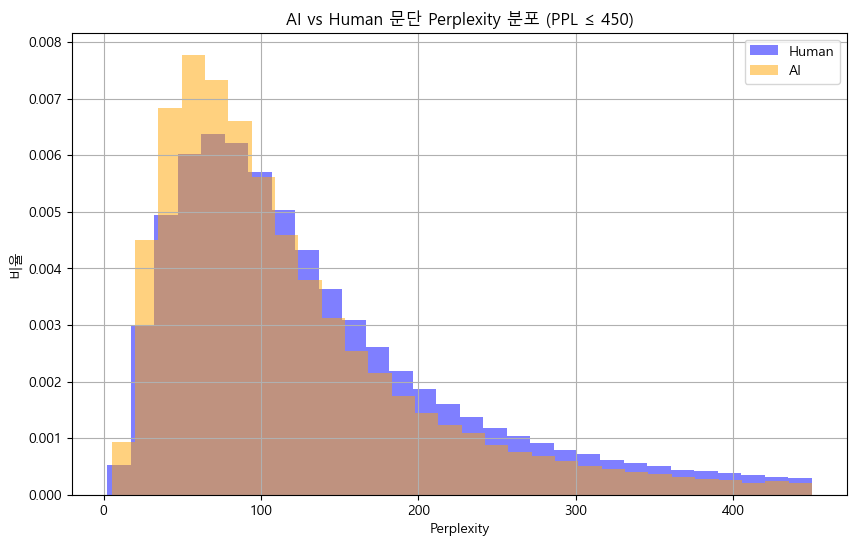

In [21]:
import matplotlib.pyplot as plt

# 전체 개수 기준으로 필터링 전
total_human = len(human_ppl)
total_ai = len(ai_ppl)

# 450 이하만 필터링
filtered_human_ppl = human_ppl[human_ppl < 450]
filtered_ai_ppl = ai_ppl[ai_ppl < 450]

# 평균 및 중앙값 계산
mean_human = filtered_human_ppl.mean()
median_human = filtered_human_ppl.median()
mean_ai = filtered_ai_ppl.mean()
median_ai = filtered_ai_ppl.median()

# 비율 계산
ratio_human = len(filtered_human_ppl) / total_human * 100
ratio_ai = len(filtered_ai_ppl) / total_ai * 100

# 결과 출력
print("📊 Perplexity 통계 (PPL ≤ 450)")
print(f"🧠 Human 평균: {mean_human:.2f}, 중앙값: {median_human:.2f}, 문단 비율: {ratio_human:.2f}%")
print(f"🤖 AI 평균: {mean_ai:.2f}, 중앙값: {median_ai:.2f}, 문단 비율: {ratio_ai:.2f}%")

# 히스토그램 (정규화)
plt.figure(figsize=(10, 6))
plt.hist(filtered_human_ppl, bins=30, alpha=0.5, label='Human', color='blue', density=True)
plt.hist(filtered_ai_ppl, bins=30, alpha=0.5, label='AI', color='orange', density=True)
plt.xlabel('Perplexity')
plt.ylabel('비율')
plt.title('AI vs Human 문단 Perplexity 분포 (PPL ≤ 450)')
plt.legend()
plt.grid(True)
plt.show()


<Axes: xlabel='perplexity', ylabel='Density'>

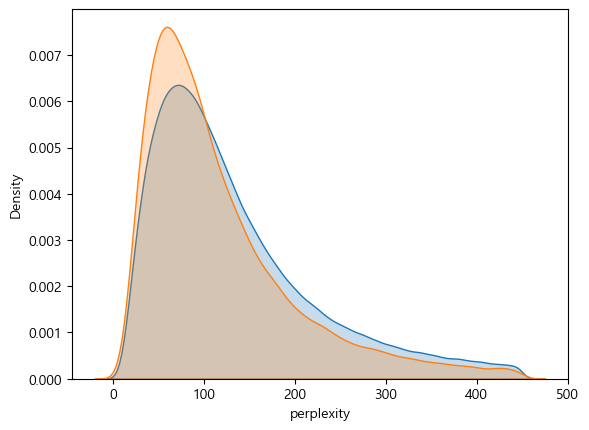

In [22]:
import seaborn as sns
sns.kdeplot(filtered_human_ppl, label="Human", fill=True)
sns.kdeplot(filtered_ai_ppl, label="AI", fill=True)


Text(0, 0.5, 'Cumulative Probability')

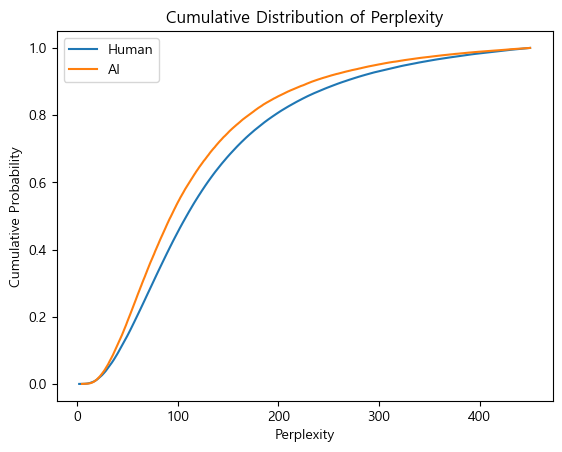

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdf(data, label):
    sorted_data = np.sort(data)
    cdf = np.arange(len(sorted_data)) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plot_cdf(filtered_human_ppl, "Human")
plot_cdf(filtered_ai_ppl, "AI")
plt.legend()
plt.title("Cumulative Distribution of Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Cumulative Probability")


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Type', ylabel='Perplexity'>

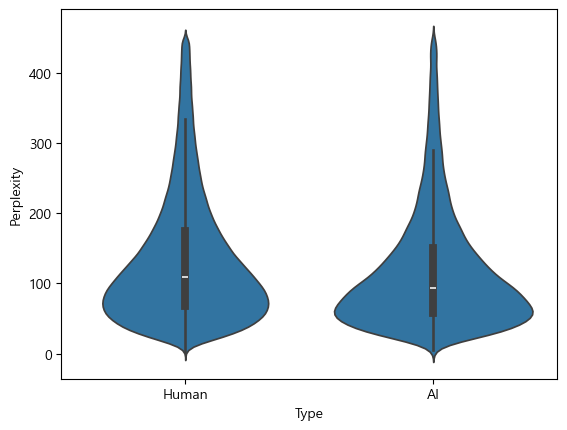

In [24]:
import seaborn as sns
import pandas as pd

combined_df = pd.DataFrame({
    'Perplexity': list(filtered_human_ppl) + list(filtered_ai_ppl),
    'Type': ['Human'] * len(filtered_human_ppl) + ['AI'] * len(filtered_ai_ppl)
})

sns.violinplot(x='Type', y='Perplexity', data=combined_df)


In [20]:
import pandas as pd
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
import torch
import math
import kss  # 문장 분리용
from tqdm import tqdm

# 전체 출력 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', trust_remote_code=True, use_safetensors=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Perplexity 계산 함수
def calculate_perplexity(text):
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=1024)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        ppl = torch.exp(loss)
        return ppl.item()

# CSV 로드
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# generated == 1 필터링 후 샘플 일부만 사용 (예: 상위 100개 문단)
df_gen = df[df['generated'] == 1].sample(n=10, random_state=19).reset_index(drop=True)

# 문장을 저장할 리스트
sentence_records = []

# 문장별로 나눠서 perplexity 계산
for _, row in tqdm(df_gen.iterrows(), total=len(df_gen)):
    paragraph = str(row['paragraph_text'])
    sentences = kss.split_sentences(paragraph)

    for idx, sentence in enumerate(sentences):
        try:
            ppl = calculate_perplexity(sentence)
        except Exception as e:
            ppl = None  # 오류 발생 시 None으로 처리
        sentence_records.append({
            'ID': row['ID'],
            'title': row['title'],
            'paragraph_index': row['paragraph_index'],
            'sentence_index': idx,
            'sentence': sentence,
            'perplexity': ppl
        })

# 결과 DataFrame
df_sentences = pd.DataFrame(sentence_records)

# 결과 미리보기
print(df_sentences.head(30))


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
100%|██████████| 10/10 [00:00<00:00, 23.11it/s]

               ID            title  paragraph_index  sentence_index  \
0    TRAIN_854257      데이크스트라 알고리즘               22               0   
1    TRAIN_854257      데이크스트라 알고리즘               22               1   
2    TRAIN_176322         잉그리드 버그먼                7               0   
3    TRAIN_176322         잉그리드 버그먼                7               1   
4    TRAIN_176322         잉그리드 버그먼                7               2   
5    TRAIN_472238   지역별 재외한인 현황 중국                9               0   
6   TRAIN_1063024              이동인               24               0   
7   TRAIN_1063024              이동인               24               1   
8   TRAIN_1063024              이동인               24               2   
9    TRAIN_409924               안근               23               0   
10   TRAIN_980115          알자라리 요새               11               0   
11   TRAIN_980115          알자라리 요새               11               1   
12   TRAIN_980115          알자라리 요새               11               2   
13   T

In [62]:
import pandas as pd
import kss

# 데이터 불러오기
df = pd.read_csv('train_paragraphs.csv', encoding='utf-8-sig')

# 문장별 정보 저장 리스트
sentence_data = []

# 문단을 문장으로 분해하고 각 문장 길이 및 생성여부 저장
for _, row in df.iterrows():
    paragraph = str(row['paragraph_text'])
    label = row['generated']  # 0: Human, 1: AI
    try:
        sentences = kss.split_sentences(paragraph, backend='mecab')
    except:
        continue  # 분리 실패 시 건너뜀

    for s in sentences:
        sentence_data.append({
            'generated': label,
            'sentence': s,
            'length': len(s)
        })

# 데이터프레임으로 변환
sentence_df = pd.DataFrame(sentence_data)

# 확인
print(sentence_df.head())

# CSV로 저장하고 싶다면 (선택)
# sentence_df.to_csv('sentence_with_length.csv', index=False, encoding='utf-8-sig')

   generated                                                           sentence  length
0          0     카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5km2, 높이는 452m이다.      62
1          0                   하와이 제도에서 가장 작은 화산섬이자 무인도이며 길이는 18km, 너비는 10km이다.      48
2          0                마우이섬에서 남서쪽으로 약 11km 정도 떨어진 곳에 위치하며 라나이섬의 남동쪽에 위치한다.      51
3          0  고도가 낮고 북동쪽에서 불어오는 무역풍을 통해 산악 지대에서 내리는 비를 형성하지 못하기 때문에 건조한 기후를 띤다.      65
4          0                  마우이섬 화산의 비그늘에 속해 있기 때문에 섬 전체 면적의 1/4 이상이 부식되어 있다.      49


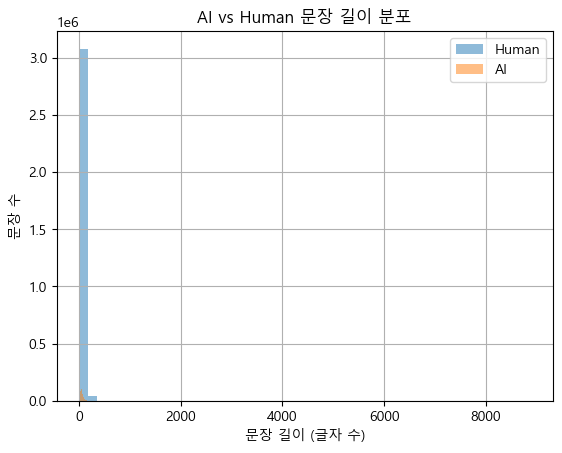

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# 문장 길이 추출
human_lengths = sentence_df[sentence_df['generated'] == 0]['length']
ai_lengths = sentence_df[sentence_df['generated'] == 1]['length']

# 히스토그램
plt.hist(human_lengths, bins=50, alpha=0.5, label='Human')
plt.hist(ai_lengths, bins=50, alpha=0.5, label='AI')
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('문장 수')
plt.title('AI vs Human 문장 길이 분포')
plt.legend()
plt.grid(True)
plt.show()

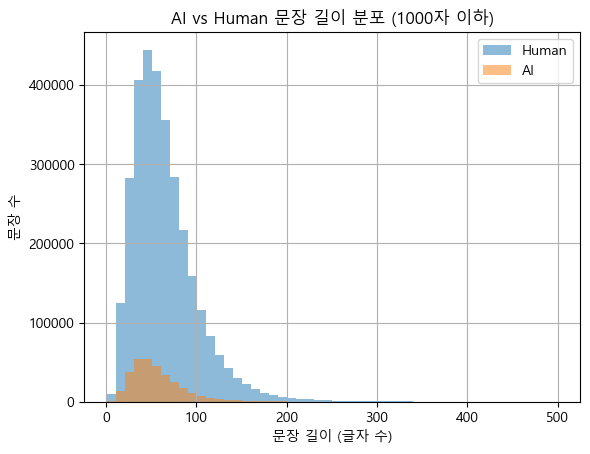

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 문장 길이 1000자 이하로 필터링
filtered_human = sentence_df[(sentence_df['generated'] == 0) & (sentence_df['length'] <= 500)]['length']
filtered_ai = sentence_df[(sentence_df['generated'] == 1) & (sentence_df['length'] <= 500)]['length']

# 히스토그램
plt.hist(filtered_human, bins=50, alpha=0.5, label='Human')
plt.hist(filtered_ai, bins=50, alpha=0.5, label='AI')
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('문장 수')
plt.title('AI vs Human 문장 길이 분포 (1000자 이하)')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
# 평균 문장 길이 계산
human_mean = sentence_df[sentence_df['generated'] == 0]['length'].mean()
ai_mean = sentence_df[sentence_df['generated'] == 1]['length'].mean()

# 출력
print(f"🧠 Human 평균 문장 길이: {human_mean:.2f}자")
print(f"🤖 AI 평균 문장 길이: {ai_mean:.2f}자")


🧠 Human 평균 문장 길이: 64.79자
🤖 AI 평균 문장 길이: 56.61자


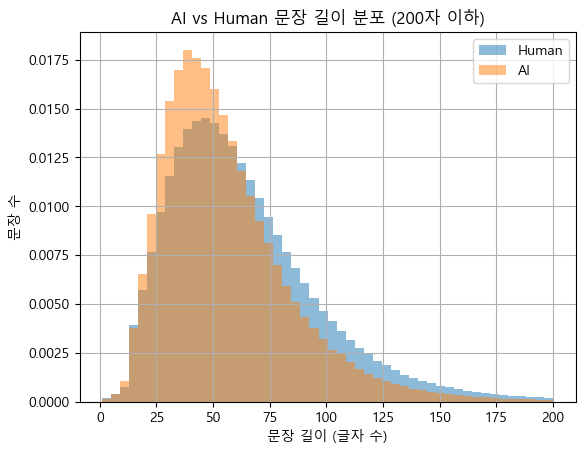

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# 문장 길이 1000자 이하로 필터링
filtered_human = sentence_df[(sentence_df['generated'] == 0) & (sentence_df['length'] <= 200)]['length']
filtered_ai = sentence_df[(sentence_df['generated'] == 1) & (sentence_df['length'] <= 200)]['length']

# 히스토그램
plt.hist(filtered_human, bins=50, alpha=0.5, label='Human',density=True)
plt.hist(filtered_ai, bins=50, alpha=0.5, label='AI',density=True)
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('문장 수')
plt.title('AI vs Human 문장 길이 분포 (200자 이하)')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
import numpy as np

# IQR 함수 정의
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

# 전체 문장 길이 기준으로 이상치 탐지
lower, upper = detect_outliers(sentence_df['length'])

# 이상치 문장 필터링
outlier_sentences = sentence_df[(sentence_df['length'] < lower) | (sentence_df['length'] > upper)]

# 결과 출력
print(f"이상치 문장 수: {len(outlier_sentences)}개 (범위: <{lower:.2f}, >{upper:.2f})\n")
print(outlier_sentences[['generated', 'length', 'sentence']].head(10))  # 상위 10개만 미리보기


이상치 문장 수: 121693개 (범위: <-22.50, >141.50)

     generated  length                                                                                                                                                                       sentence
49           0     146                             그밖에도 성단의 주계열에서 뚜렷하게 관측되는 밝은 청색 별로 이러한 광도의 주계열성은 성단의 나이를 따지면 이미 거성이나 초거성으로 진화했어야 하는 청색낙오성과, 청색거성을 지나서 진화한 매우 무거운 별으로 스펙트럼의 큰 팽창 효과로 구별되는 청색초거성이 있다.
148          0     172   1941년까지 정력적인 기업가는 많은 시장을 구축했지만, 그해에 그는 기본적으로 그의 개인 소유 사업에서 미그로스 협동조합 연합("Migros-Genossenschafts-Bund")이 이끄는 지역 협동조합(regional cooperatives)으로 모든 것을 변화시킴으로써 그의 고객들에게 사업을 주었다.
234          0     143                                나리타 익스프레스(, )는 동일본여객철도(JR 동일본)가 오후나 역(일부는 요코스카 역), 요코하마 역, 다카오 역(일부는 후지 급행선 가와구치코 역), 오미야 역, 이케부쿠로 역, 신주쿠 역, 시나가와 역 ~ 나리타 공항역 간을 운행하는 특별급행열차이다.
238          0     158                 그러다가 당시 운수 대신(運輸大臣)이었던 이시하라 신타로가 지시하여, 건설이 중단된 나리타 신칸센의 노반과 역 등의 설비를 활용하여 1991년 3월 19일에 동일본여객철도 및 게이세이 전철의 공항 연계 철도 운행이 가능하게 하였

In [77]:
# 전체 문장 수
total_sentences = len(sentence_df)

# 200자 이하 문장 수
under_200 = sentence_df[sentence_df['length'] <= 200].shape[0]

# 비율 계산
ratio = under_200 / total_sentences

print(f"📏 200자 이하 문장 수: {under_200} / {total_sentences}")
print(f"✅ 200자 이하 비율: {ratio:.4f} ({ratio*100:.2f}%)")

for label, name in [(0, "Human"), (1, "AI")]:
    subset = sentence_df[sentence_df['generated'] == label]
    total = len(subset)
    under_200 = subset[subset['length'] <= 200].shape[0]
    ratio = under_200 / total
    print(f"🔍 {name}: {under_200} / {total} ({ratio*100:.2f}%) 200자 이하 문장 비율")


📏 200자 이하 문장 수: 3415971 / 3442137
✅ 200자 이하 비율: 0.9924 (99.24%)
🔍 Human: 3098021 / 3122978 (99.20%) 200자 이하 문장 비율
🔍 AI: 317950 / 319159 (99.62%) 200자 이하 문장 비율


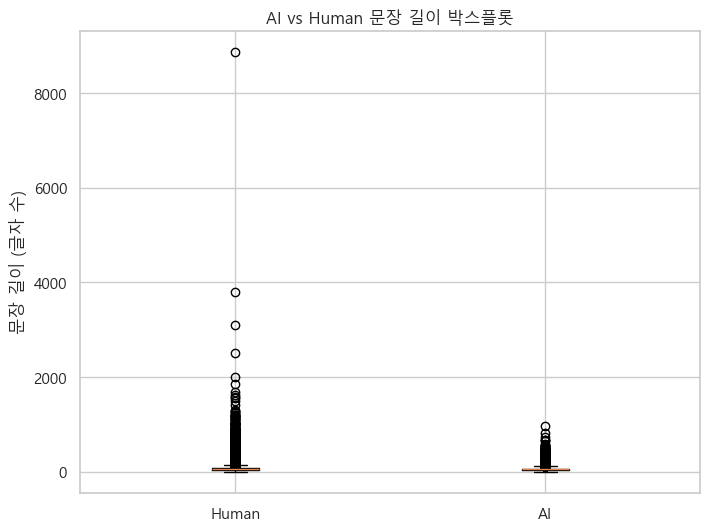

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (Windows용)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 문장 길이 추출
human_lengths = sentence_df[sentence_df['generated'] == 0]['length'].tolist()
ai_lengths = sentence_df[sentence_df['generated'] == 1]['length'].tolist()

# 박스플롯 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([human_lengths, ai_lengths], labels=['Human', 'AI'], showfliers=True)
plt.ylabel('문장 길이 (글자 수)')
plt.title('AI vs Human 문장 길이 박스플롯')
plt.grid(True)
plt.show()


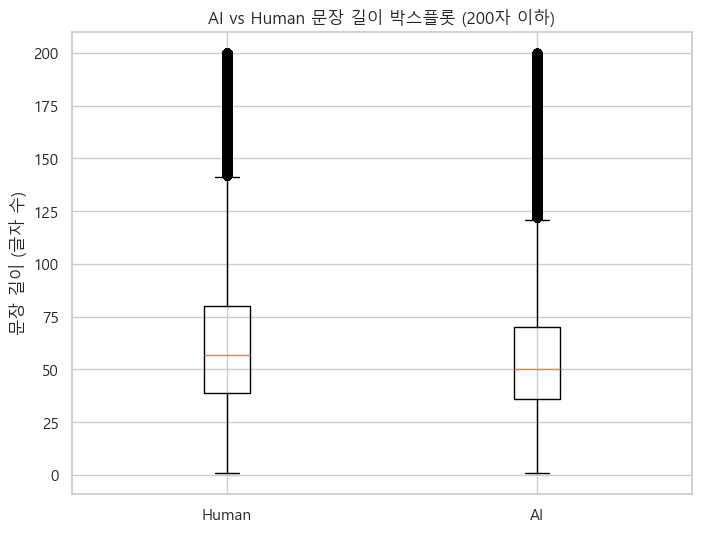

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# ✅ 한글 폰트 설정 (Windows 기준)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 문장 길이 200자 이하만 필터링
filtered = sentence_df[sentence_df['length'] <= 200]
human_lengths = filtered[filtered['generated'] == 0]['length'].tolist()
ai_lengths = filtered[filtered['generated'] == 1]['length'].tolist()

# 박스플롯 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([human_lengths, ai_lengths], labels=['Human', 'AI'], showfliers=True)
plt.ylabel('문장 길이 (글자 수)')
plt.title('AI vs Human 문장 길이 박스플롯 (200자 이하)')
plt.grid(True)
plt.show()


In [84]:
# 8000자 이상 문장 필터링
long_sentences = sentence_df[sentence_df['length'] >= 8000]

# 개수 출력
print(f"📌 8000자 이상 문장 개수: {len(long_sentences)}개")

# 해당 문장들 출력 (길이와 함께)
for idx, row in long_sentences.iterrows():
    print(f"\n📄 문장 (길이: {row['length']}자):\n")
    print(row['sentence'])


📌 8000자 이상 문장 개수: 1개

📄 문장 (길이: 8872자):

이러한 재식별은 후속 간행물에서 연구자들이 호의를 보였으며 더 이상의 설명 없이 '프로사우루드' 계열의 안치사우루스과와 테코돈토사우루스과'를 다양하게 언급하였다. 두투이트 자신은 아젠도사우루스가 1983년에 '프로사우루포드'일 가능성이 높다는 데 동의하기도 했지만 1981년에 얼마 전까지만 해도 '오르니티슈 이전'으로 간단히 간주했었다. 1985년에 궁중학자인 피터 갈튼은 치아의 형태 차이를 근거로 두투이트의 원래 "아잔도사우루스" 재료에 "프로사우루포드"의 턱과 파브로사우루스 오르니티스치안(지금은 초기 오르니티스치안들의 없어진 그룹)의 이빨이 포함되었다고 제안했다. 이 제안은 1993년에 프랑수아-자비에르 가우프레가 재설명할 때 반박했고 최대 2개의 턱뼈와 치아를 추가로 묘사했다. 그는 이 물질이 단일 세손에 속한다고 정확하게 결론을 내렸으나 턱과 치아의 특성에 따라 다시 "프로사우로포다" 인서태 세디스에 속주를 할당했다. 그러나 초기의 초식공룡에서 이러한 특성의 분포가 모호할 뿐만 아니라 그에 필적할 만한 트라이아스기 파충류도 없어 '프로사우로포다' 내에서 위치를 결정하지 못했기 때문에 인서태 세디스(Intertae sedis)에 회부했다. 그의 평가는 마다가스카나 종에서 나온 새로운 물질에 대한 설명이 있을 때까지 수 년 동안 많은 다른 연구자들에 의해 받아들여졌다. 후두골 골격의 일부를 포함한 A. 라루시 유형의 지역성에서 나온 새로운 물질은 2002년 자릴과 카릴에 의해 척추동물 고생물학 협회의 연례 회의에서 보고되었다. 추가 재료로는 전치골, 사지골, 사지거들 등이 있었다. 이 물질은 분리되었고, 두개골과 턱의 공인된 파편과의 연관성 때문에 A. 라로시이의 탓만 있었다. 크라니안 후 물질은 비공룡으로 인식되었지만 여전히 공룡과 관련된 오르니토디란 대공룡으로 여겨지고 있다. 만약 턱과 이빨과 정확히 연관되었다면, 이것은 아젠도사우루스가 유사함에도 불구하고 어떤 초식 공룡과도 밀접

In [85]:
# 8000자 이상 문장 필터링
long_sentences = sentence_df[sentence_df['length'] >= 8000]

# 개수 출력
print(f"📌 8000자 이상 문장 개수: {len(long_sentences)}개")

# 전체 정보 출력
for idx, row in long_sentences.iterrows():
    print(f"\n🔍 인덱스 {idx} - 전체 정보:")
    for col in row.index:
        print(f"{col}: {row[col]}")
    print("\n" + "-"*80)


📌 8000자 이상 문장 개수: 1개

🔍 인덱스 3000272 - 전체 정보:
generated: 0
sentence: 이러한 재식별은 후속 간행물에서 연구자들이 호의를 보였으며 더 이상의 설명 없이 '프로사우루드' 계열의 안치사우루스과와 테코돈토사우루스과'를 다양하게 언급하였다. 두투이트 자신은 아젠도사우루스가 1983년에 '프로사우루포드'일 가능성이 높다는 데 동의하기도 했지만 1981년에 얼마 전까지만 해도 '오르니티슈 이전'으로 간단히 간주했었다. 1985년에 궁중학자인 피터 갈튼은 치아의 형태 차이를 근거로 두투이트의 원래 "아잔도사우루스" 재료에 "프로사우루포드"의 턱과 파브로사우루스 오르니티스치안(지금은 초기 오르니티스치안들의 없어진 그룹)의 이빨이 포함되었다고 제안했다. 이 제안은 1993년에 프랑수아-자비에르 가우프레가 재설명할 때 반박했고 최대 2개의 턱뼈와 치아를 추가로 묘사했다. 그는 이 물질이 단일 세손에 속한다고 정확하게 결론을 내렸으나 턱과 치아의 특성에 따라 다시 "프로사우로포다" 인서태 세디스에 속주를 할당했다. 그러나 초기의 초식공룡에서 이러한 특성의 분포가 모호할 뿐만 아니라 그에 필적할 만한 트라이아스기 파충류도 없어 '프로사우로포다' 내에서 위치를 결정하지 못했기 때문에 인서태 세디스(Intertae sedis)에 회부했다. 그의 평가는 마다가스카나 종에서 나온 새로운 물질에 대한 설명이 있을 때까지 수 년 동안 많은 다른 연구자들에 의해 받아들여졌다. 후두골 골격의 일부를 포함한 A. 라루시 유형의 지역성에서 나온 새로운 물질은 2002년 자릴과 카릴에 의해 척추동물 고생물학 협회의 연례 회의에서 보고되었다. 추가 재료로는 전치골, 사지골, 사지거들 등이 있었다. 이 물질은 분리되었고, 두개골과 턱의 공인된 파편과의 연관성 때문에 A. 라로시이의 탓만 있었다. 크라니안 후 물질은 비공룡으로 인식되었지만 여전히 공룡과 관련된 오르니토디란 대공룡으로 여겨지고 있다. 만약 턱과 이빨과 정확히 연관되었다면, 이것은 아젠도사우루

In [88]:
import torch; print(torch.__version__)

2.5.1+cu121
